In [9]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget

In [10]:
import torch
import torchvision
from PIL import Image
from io import BytesIO
import numpy as np
import requests
import os

# false positives
193884,
238866,
466835,
468233,
575815,

# 예시 image ID
image_id = 466835
image_filename = f"{image_id:012d}.jpg"
image_path = os.path.join("/media/data/coco/images/val2017", image_filename)

# 이미지 열기
image = Image.open(image_path).convert("RGB")

# numpy 변환 및 전처리
image_np = np.array(image)
image_float_np = np.float32(image_np) / 255.0

# torchvision transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가

# 모델 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)

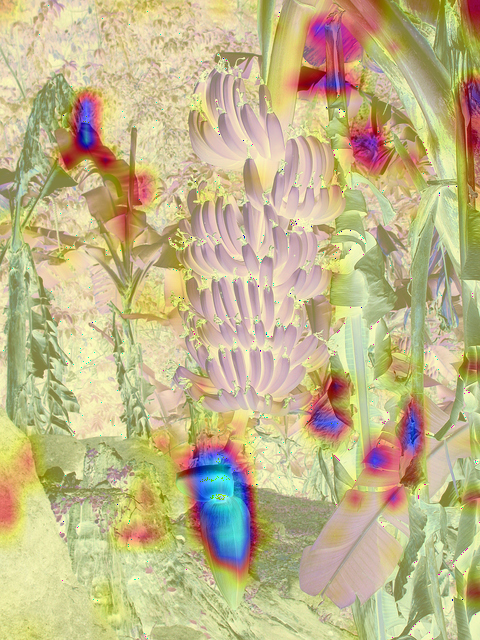

: 

In [ ]:
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. 모델 불러오기 및 설정
model = fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)
target_layer = model.backbone.body.layer4
cam = GradCAM(model=model, target_layers=[target_layer])

# 2. 추론
with torch.no_grad():
    outputs = model(input_tensor)

# 3. confidence threshold 이상인 박스 선택
threshold = 0.5
boxes = outputs[0]['boxes']
labels = outputs[0]['labels']
scores = outputs[0]['scores']

selected_indices = (scores > threshold).nonzero(as_tuple=True)[0]

# 4. Grad-CAM target 생성
targets = []
for idx in selected_indices:
    box = boxes[idx].detach().cpu().numpy()
    label = labels[idx].item()
    targets.append(FasterRCNNBoxScoreTarget(bounding_boxes=[box], labels=[label]))

# 5. Grad-CAM 실행
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

# 6. 시각화
image_np_float = np.float32(image_np) / 255.0
visualization = show_cam_on_image(image_np_float, grayscale_cam, use_rgb=True)

# 7. 결과 표시
Image.fromarray((visualization * 255).astype(np.uint8))